In [1]:
import os

%load_ext autoreload
%autoreload 2

%matplotlib inline

%cd ../..

!hostname

/p/fastdata/pli/Private/oberstrass1/datasets/vervet1818-3d
jrlogin08.jureca


In [2]:
import pli
import pli.image as im

import numpy as np

from tqdm import tqdm

In [3]:
feature_path = "data/aa/features/resnet50_planes8/"
mask_path = "data/aa/masks/tissue/"

###

feature_list = [os.path.join(feature_path, f) for f in sorted(os.listdir(feature_path))]
mask_list = [os.path.join(mask_path, f) for f in sorted(os.listdir(mask_path))]

assert len(feature_list) == len(mask_list), "Need same number of features and masks"

In [4]:
data_group = 'Features/256'
pyramid_level = 7
mask_level = 7

###

from skimage.util.shape import view_as_windows

# https://stackoverflow.com/questions/48097941/strided-convolution-of-2d-in-numpy
def strided4D(arr,arr2,s):
    return view_as_windows(arr, arr2.shape, step=s)

def stride_conv_strided(arr,arr2,s):
    arr4D = strided4D(arr,arr2,s=s)
    return np.tensordot(arr4D, arr2, axes=((2,3),(0,1)))

def read_section(feature_path, mask_path, mask_in_pyramid=2, mask_out_pyramid=7):
    WM = 1
    GM = 2
    BG = 3

    feature_section = pli.data.Section(feature_path, data_group=data_group)
    mask_section = pli.data.Section(mask_path)

    mask_raw = mask_section.pyramid[mask_in_pyramid][:]

    stride = 2 ** (mask_out_pyramid - mask_in_pyramid)
    kernel = np.ones((stride, stride))

    pyr_wm = mask_raw == WM
    pyr_gm = mask_raw == GM
    pyr_bg = mask_raw == BG
    wm_scores = stride_conv_strided(pyr_wm, kernel, stride)
    gm_scores = stride_conv_strided(pyr_gm, kernel, stride)
    bg_scores = stride_conv_strided(pyr_bg, kernel, stride)

    stacked = np.stack([wm_scores, gm_scores, bg_scores])
    mask = (np.argmax(stacked, axis=0) + 1).astype(np.uint8)

    features = feature_section.image[:].transpose(1, 2, 0)

    if features.shape[0] >  mask.shape[0]:
        features = features[:-1]
    if features.shape[1] >  mask.shape[1]:
        features = features[:, :-1]

    return features, mask

In [5]:
n_subsamples = 32  # Number of randomly selected sections
seed = 299792458

###

np.random.seed(seed)
select_ix = np.random.choice(np.arange(len(feature_list)), n_subsamples)

selected_features = []
selected_masks = []

for ix in tqdm(select_ix):
    features, mask = read_section(feature_list[ix], mask_list[ix])
    assert features.shape[:2] == mask.shape, f"{features.shape[:2]} differs from {mask.shape}"
    selected_features.append(features)
    selected_masks.append(mask)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:16<00:00,  1.98it/s]


In [6]:
valid_features = [f[m < 3] for f, m in zip(selected_features, selected_masks)]
valid_lengths = [len(vf) for vf in valid_features]
valid_features = np.vstack(valid_features)

In [7]:
pca_components = len(valid_features[0])

###

from sklearn.decomposition import PCA

pca = PCA(n_components=pca_components, svd_solver='full')
pca.fit(valid_features)

PCA(n_components=256, svd_solver='full')

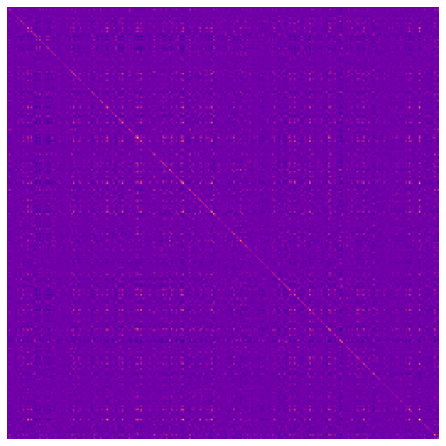

In [8]:
feature_cov = pca.get_covariance()

im.show(feature_cov, cmap='plasma');

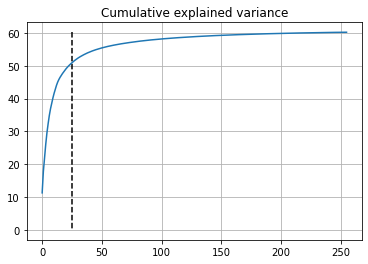

In [35]:
n_components = 25

###

import matplotlib.pyplot as plt

scree = np.cumsum(pca.explained_variance_)

plt.plot(scree)
plt.vlines(n_components, scree.max(), 0, colors='black', linestyles='--')
plt.title("Cumulative explained variance")
plt.grid()
plt.show()

In [10]:
valid_components = pca.transform(valid_features)[:, :n_components]
valid_components.shape

(533529, 25)

In [26]:
n_clusters = 128
n_subfeatures = 32000
seed = 299792458

###

from sklearn.cluster import KMeans

np.random.seed(seed)

ix = np.random.choice(np.arange(len(valid_components)), n_subfeatures)

km = KMeans(n_clusters, n_init=5, max_iter=300, tol=1e-4, random_state=seed)
km.fit(valid_components[ix])

KMeans(n_clusters=128, n_init=5, random_state=299792458)

Test
---

Sections 841-843 were unseen during training of contrastive features

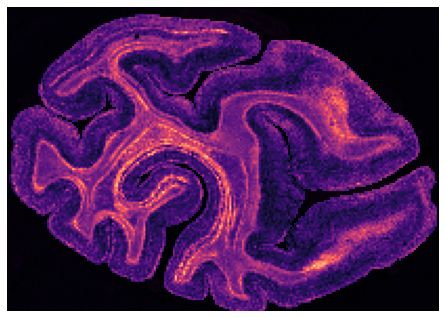

In [12]:
test_features = "datasets/vervet1818-stitched/data/aa/features/resnet50_planes8/Vervet1818aa_60mu_70ms_s0938_x00-13_y00-19_Features.h5"
test_mask = "datasets/vervet1818-stitched/data/aa/masks/tissue/Vervet1818aa_60mu_70ms_s0938_x00-13_y00-19_Mask.h5"

# Read test image for visualization

test_image, test_mask = read_section(test_features, test_mask)
test_tissue = test_mask < 3

im.show(test_image, mask=(~test_tissue).astype(np.uint8), alpha=0.9, mask_map='gray')

In [55]:
sigma = 2.0

###

from skimage import filters

valid_test = test_image[test_tissue]
valid_pca = pca.transform(valid_test)

image_pca = np.zeros_like(test_image)
image_pca[test_tissue] = valid_pca

image_pca_smoothed = filters.gaussian(image_pca, multichannel=True, sigma=sigma)
valid_pca_smoothed = image_pca_smoothed[test_tissue]

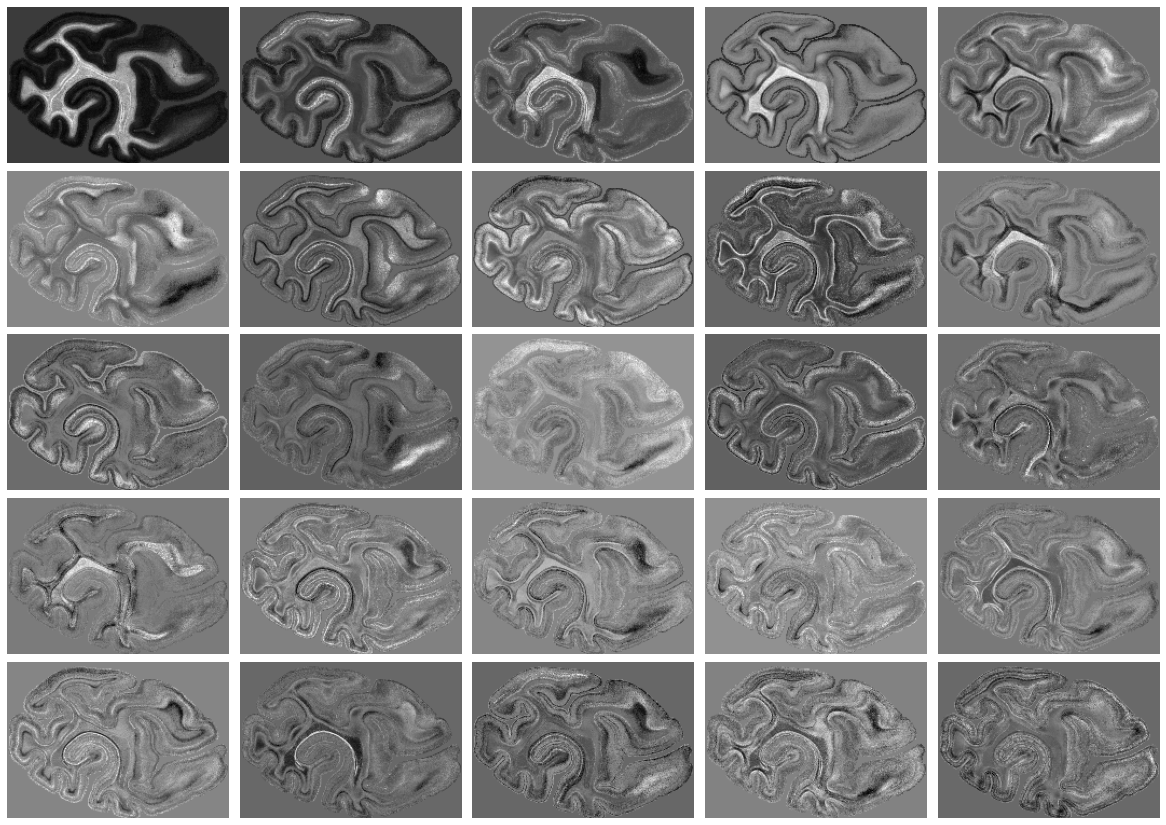

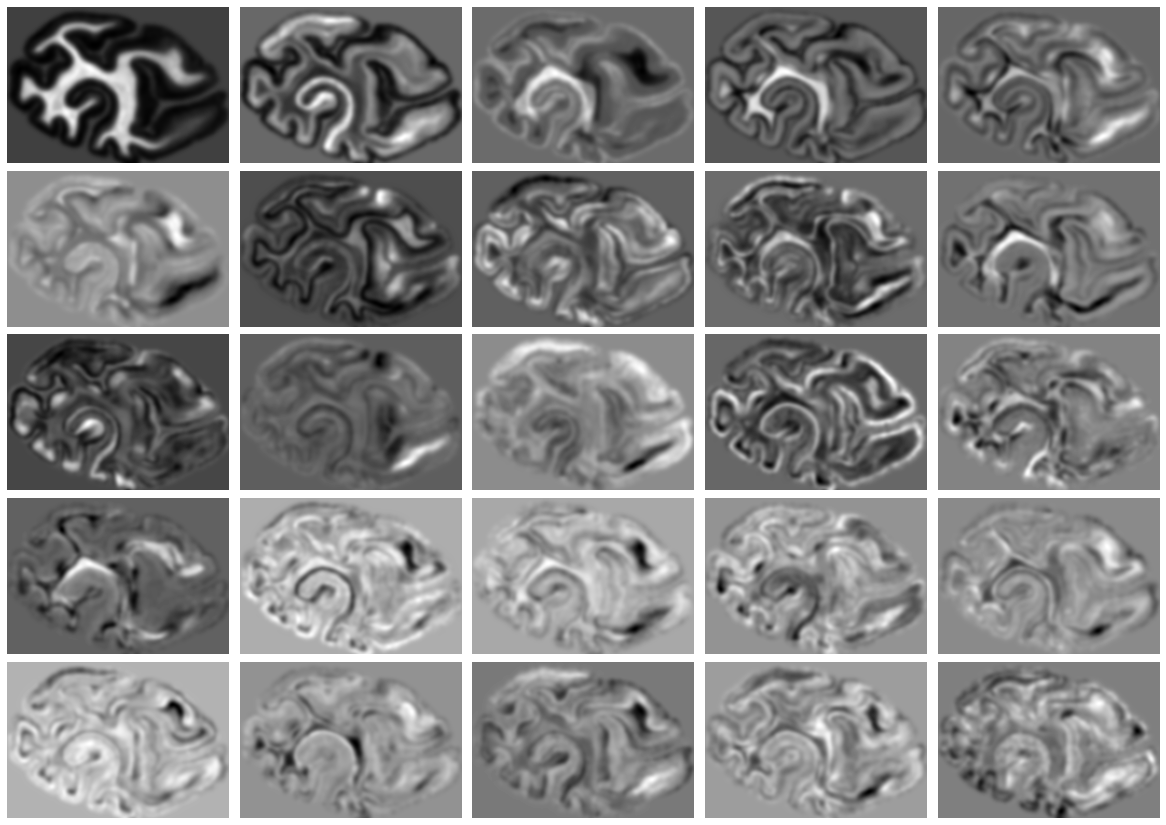

In [56]:
plot_components = 25

###

im.show(np.stack([image_pca[..., i] for i in range(plot_components)]), ch='NHW', size=16) #, file=f"data/aa/clusters/pca/pca_resnet50_planes8_{plot_components}_s0841")
im.show(np.stack([image_pca_smoothed[..., i] for i in range(plot_components)]), ch='NHW', size=16)

Warning! Printing mask for non integer like array


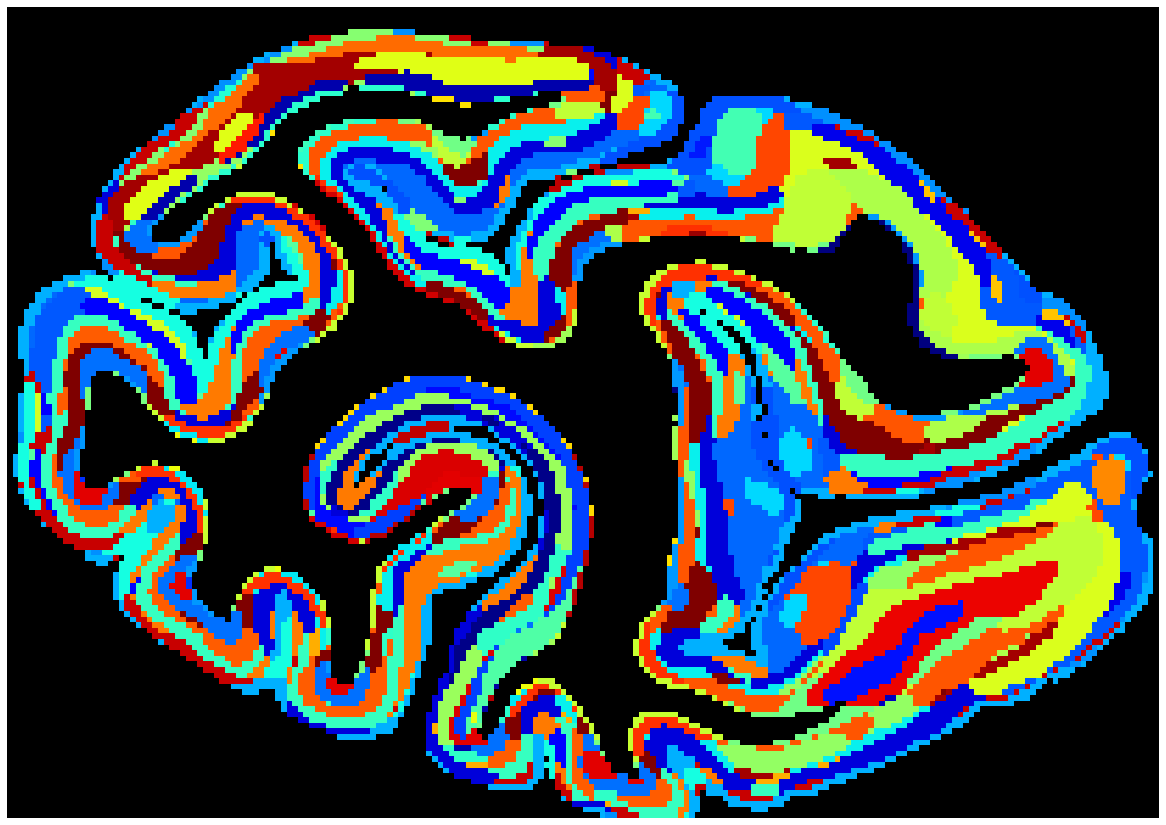

Warning! Printing mask for non integer like array


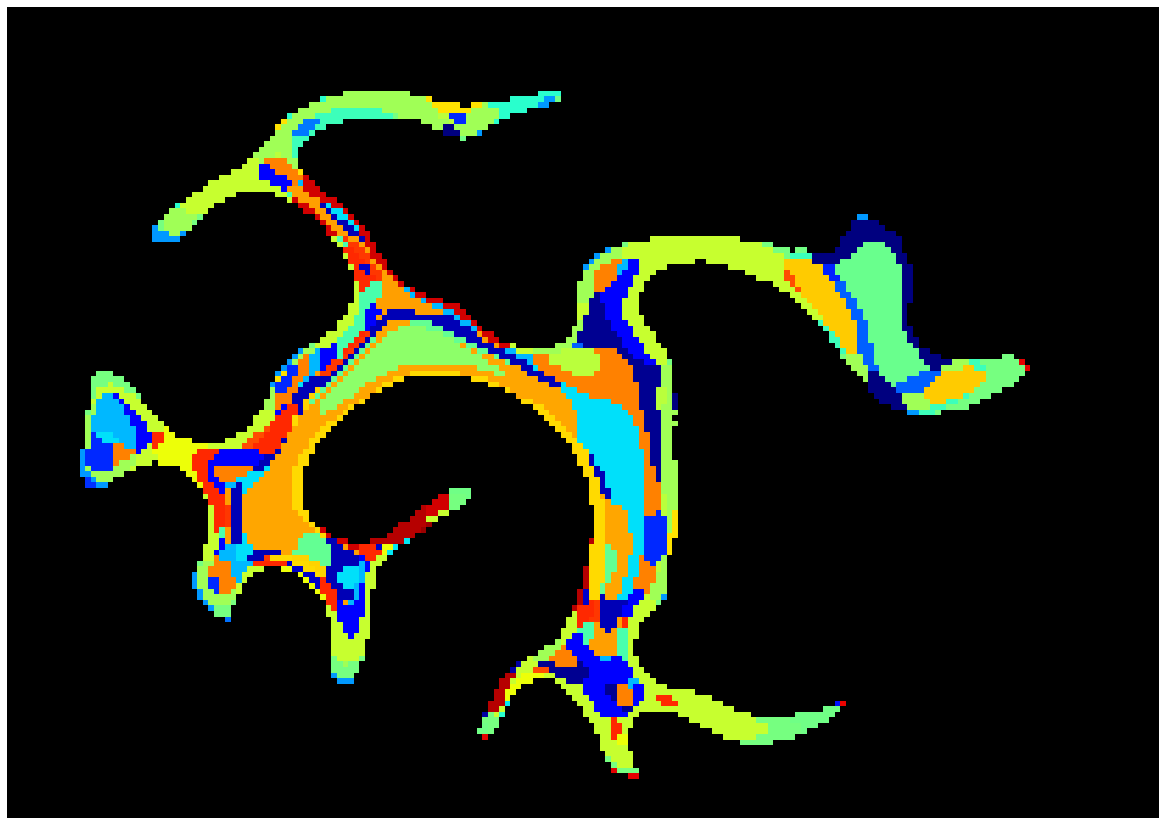

In [57]:
test_predictions = km.predict(valid_pca_smoothed[..., :n_components])

image_clusters = np.zeros(test_image.shape[:2], dtype=np.uint8)
image_clusters[test_tissue] = test_predictions

im.show(image_clusters, mask=test_mask != 2, size=16, cmap='jet', mask_map='gray', alpha=1.0)
im.show(image_clusters, mask=test_mask != 1, size=16, cmap='jet', mask_map='gray', alpha=1.0)

In [59]:
seed = 299792458
n_mappings = 20

###

from sklearn.cluster import AgglomerativeClustering

np.random.seed(seed)

ix = np.random.choice(np.arange(len(valid_components)), n_subfeatures)

# linkage{‘ward’, ‘complete’, ‘average’, ‘single’}
ac = AgglomerativeClustering(n_mappings, affinity='euclidean', linkage='ward')
cluster_mapping = ac.fit_predict(km.cluster_centers_)

Warning! Printing mask for non integer like array


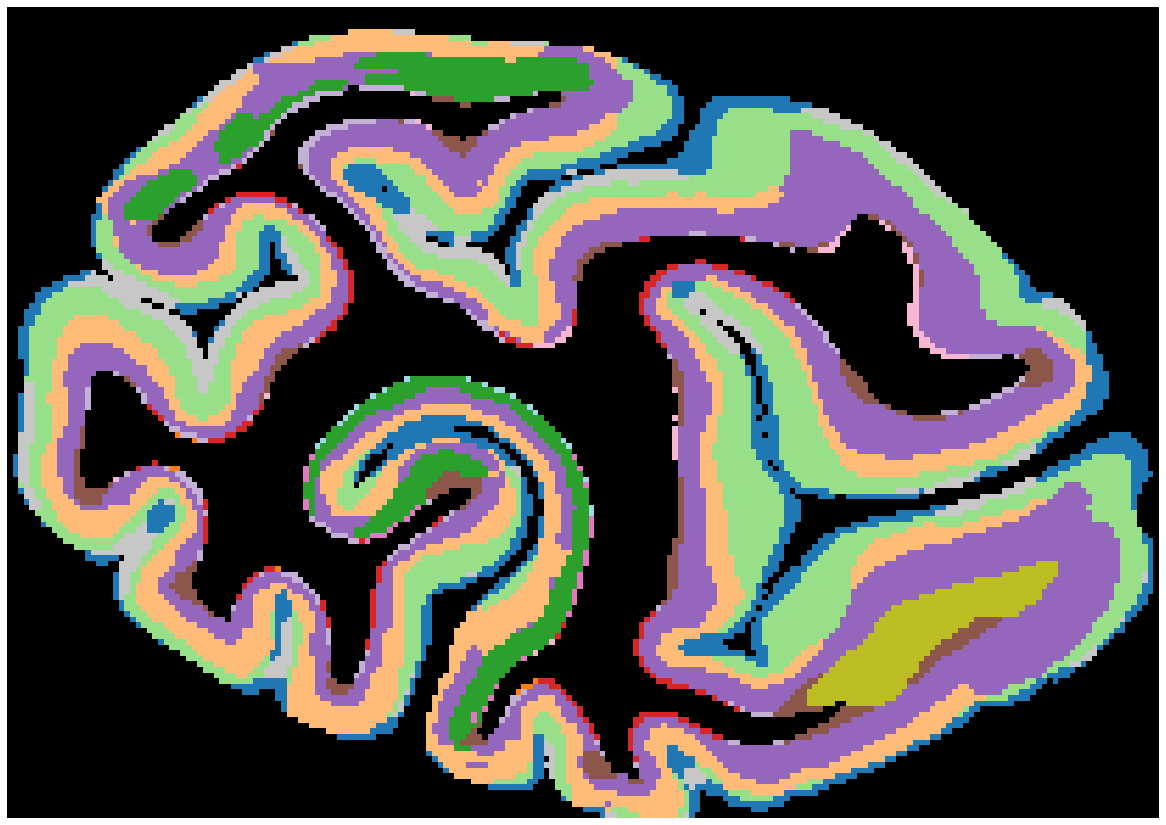

Warning! Printing mask for non integer like array


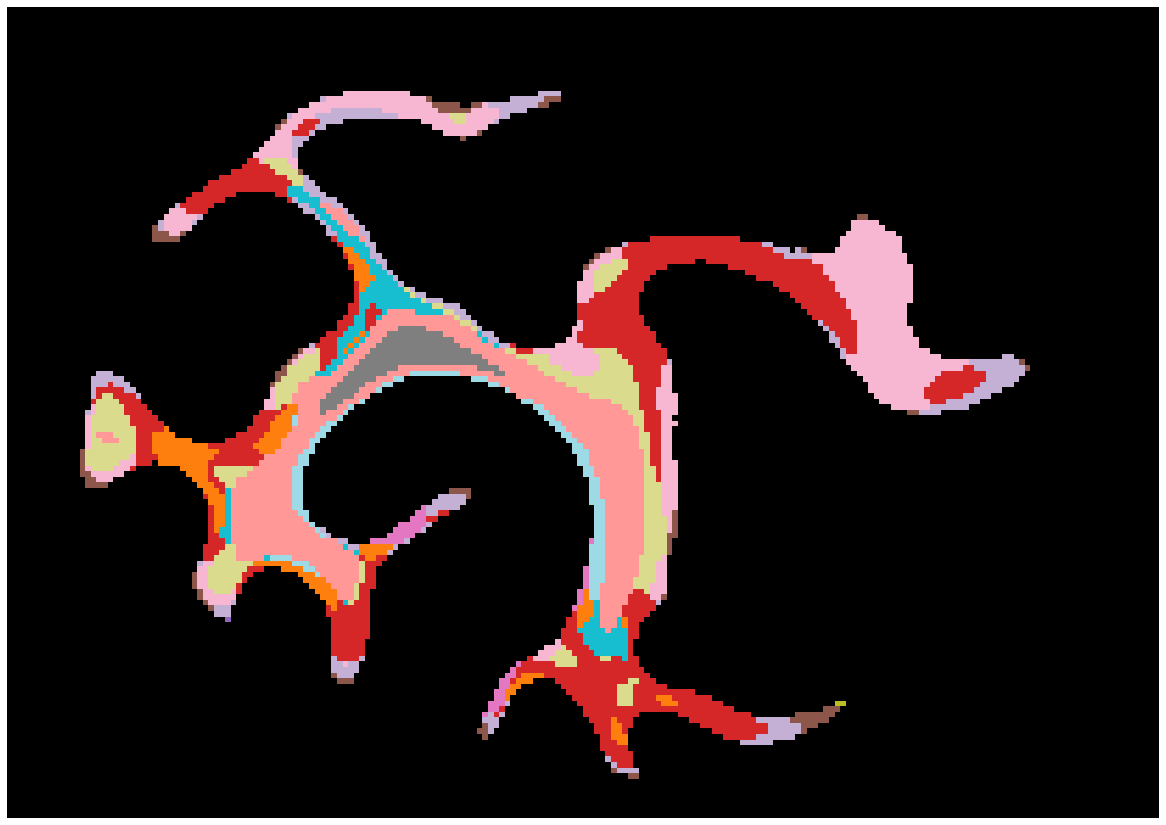

In [60]:
aggl_predictions = cluster_mapping[test_predictions]

image_clusters = np.zeros(test_image.shape[:2], dtype=np.uint8)
image_clusters[test_tissue] = aggl_predictions

im.show(image_clusters, mask=test_mask != 2, size=16, cmap='tab20', mask_map='gray', alpha=1.0)
im.show(image_clusters, mask=test_mask != 1, size=16, cmap='tab20', mask_map='gray', alpha=1.0)